# Group 96

In [45]:
import numpy as np
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.feature_extraction.image import extract_patches_2d
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

## extract patches 2d

Reshape a 2D image into a collection of patches of the choosen size.
The resulting patches are allocated in a dedicated array.

## reconstruct from patches 2d

Reconstruct the image from all of its patches.
Patches are assumed to overlap and the image is constructed by filling in the patches from left to right, top to bottom, averaging the overlapping regions.

# Data Importation

In [41]:
# Importing the training patched dataset
Xtrain_a = np.load('Xtrain2_a.npy')
Ytrain_a = np.load('Ytrain2_a.npy')



# Importing the training flattened dataset
Xtrain_b = np.load('Xtrain2_b.npy')
Ytrain_b = np.load('Ytrain2_b.npy')

In [18]:
# Imbalance in the dataset a?
print('Number of samples in class 0:', np.sum(Ytrain_a == 0))
print('Number of samples in class 1:', np.sum(Ytrain_a == 1))
print("Percentage of samples in class 1: ", (np.sum(Ytrain_a == 1)/np.sum(Ytrain_a==0))*100)

# Imbalance in the dataset b?
print('Number of samples in class 0:', np.sum(Ytrain_b == 0))
print('Number of samples in class 1:', np.sum(Ytrain_b == 1))
print("Percentage of samples in class 1: ", (np.sum(Ytrain_b == 1)/np.sum(Ytrain_b==0))*100)

Number of samples in class 0: 649624
Number of samples in class 1: 315284
Percentage of samples in class 1:  48.5333054197505
Number of samples in class 0: 896429
Number of samples in class 1: 363859
Percentage of samples in class 1:  40.58982920008166


# Data Visualization

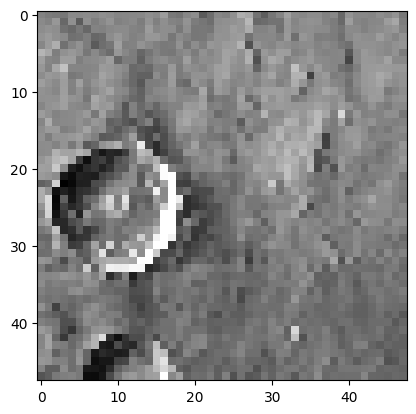

In [19]:
# Size of an image
img_size = [48,48]
# Number of patches for one image
patches = np.array(Xtrain_a[0:1764])

# Reshaping the patches
patches = patches.reshape(-1, 7, 7)
# Reconstructing the image
img_0_a = reconstruct_from_patches_2d(patches = patches, image_size=img_size )

# The image most be reshaped into a 48x48 matrix
img_0_a = img_0_a.reshape(1,48,48)
plt.imshow(img_0_a[0], cmap='gray')
plt.show()


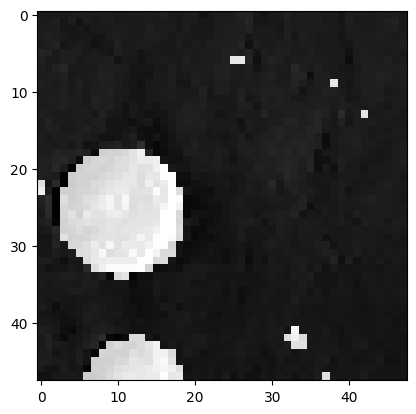

In [20]:
# Each line in the dataset b is a 2D image of 48x48 pixels
Xtrain_b_img = Xtrain_b.reshape(-1, 48, 48)
Ytrain_b_img = Ytrain_b.reshape(-1, 48,48)

# Displaying the first image and the y image
plt.imshow(Xtrain_b_img[0], cmap='gray')
plt.imshow(Ytrain_b_img[0], cmap='gray', alpha=0.8)
plt.show()

In [21]:
Xtrain_a_img = np.zeros((547, 48, 48))
for i in range(0, 547) :
    # Number of patches for one image
    patches = np.array(Xtrain_a[i*1764:(i+1)*1764])
    # Reshaping the patches
    patches = patches.reshape(-1, 7, 7)
    Xtrain_a_img[i] = reconstruct_from_patches_2d(patches = patches, image_size=img_size )

print(np.sum(Xtrain_a_img - Xtrain_b_img))

0.0


We know that the sets are based on the same images

## Splitting the data

In [42]:
# Splitting the dataset a
Xtrain_a, Xval_a, Ytrain_a, Yval_a = train_test_split(Xtrain_a, Ytrain_a, test_size=0.2, random_state=42)

# Splitting the dataset b
Xtrain_b, Xval_b, Ytrain_b, Yval_b = train_test_split(Xtrain_b, Ytrain_b, test_size=0.2, random_state=42)

# Convolutional Neural : U-NET

## Data processing

In [23]:
# Normalizing the training dataset
Xtrain_a = Xtrain_a/255
Xtrain_b = Xtrain_b/255

# Normalizing the validation dataset
Xval_a = Xval_a/255
Xval_b = Xval_b/255


## Creating the model

In [24]:
def unet_model(input_shape = (48, 48, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encode
    # Convolutions 1 + Reduction
    c1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Convolutions 2 + Reduction
    c2 = layers.Conv2D(48*2, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(48*2, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Convolutions 3 + Reduction
    c3 = layers.Conv2D(48*2*2, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(48*2*2, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Convolutions 4 + Reduction
    c4 = layers.Conv2D(48*2*2*2, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(48*2*2*2, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(48*2*2*2*2, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(48*2*2*2*2, (3, 3), activation='relu', padding='same')(c5)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u6 = layers.Conv2DTranspose(48*2*2*2, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(48*2*2*2, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(48*2*2*2, (3, 3), activation='relu', padding='same')(c6)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u7 = layers.Conv2DTranspose(48*2*2, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(48*2*2, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(48*2*2, (3, 3), activation='relu', padding='same')(c7)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u8 = layers.Conv2DTranspose(48*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(48*2, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(48*2, (3, 3), activation='relu', padding='same')(c8)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u9 = layers.Conv2DTranspose(48, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(c9)

    # Convolution for the output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [25]:
# Epochs
epochs = 500
# Batch size
batch_size = 15
# Leraning rate
lr = 0.001

In [26]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=lr)

# Method to reduce the learning rate when the validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True,verbose = 1)

adam = tf.keras.optimizers.Adam(learning_rate=lr,ema_momentum=0.9)

sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)


## Training the model

In [ ]:
model_img = unet_model()
model_img.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_img.summary()

Xtrain_b_mat= Xtrain_b.reshape(-1, 48, 48, 1)
Ytrain_b_mat = Ytrain_b.reshape(-1, 48, 48,1)

Xval_b_mat = Xval_b.reshape(-1, 48, 48, 1)
Yval_b_mat = Yval_b.reshape(-1, 48, 48,1)


history = model_img.fit(Xtrain_b_mat, Ytrain_b_mat,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(Xval_b_mat, Yval_b_mat),
                    callbacks=[reduce_lr,early_stopping]
                   )

Best obtained so far -> adam

In [ ]:
# The loss giving the epoch
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# The accuracy giving the epoch
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

# saving the model
model_img.save('/content/drive/MyDrive/MAIN /MAIN 5/S9 /Machine Learning /Classification_Problem_2/model_img.keras')
weights_img = model_img.weights

## Prédictions


/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_160']. Received: the structure of inputs=*
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 572ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step


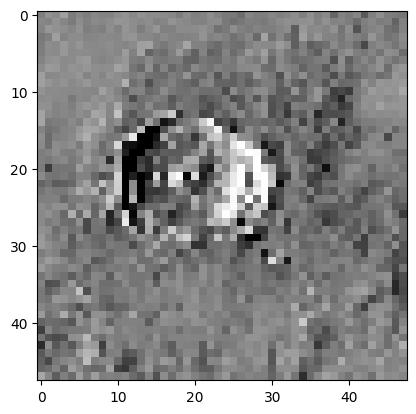

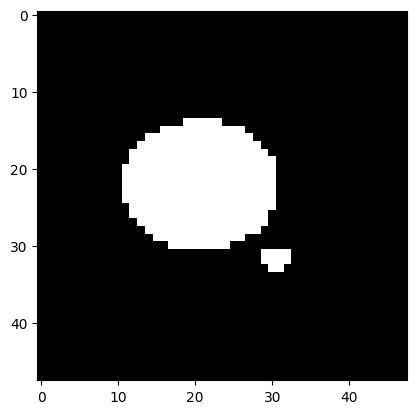

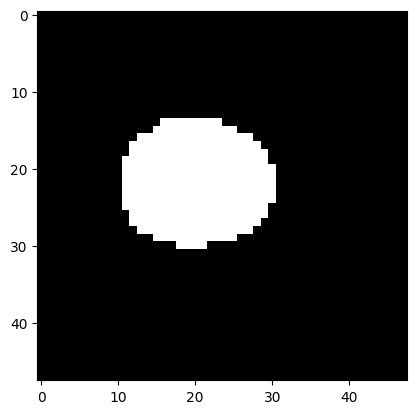

F1_score:  0.6961717723697282


In [29]:
# Charger le modèle et compiler
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights('model_img.keras') 

# Prédictions
predictions = model.predict(Xval_b_mat)

# Predictions
predictions = model.predict(Xval_b_mat)

# Reshaping the predctions
predictions = predictions.reshape(-1, 48, 48)

# Thresholding the predictions
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

# The true image and the predicted one
plt.imshow(Xval_b_mat[3], cmap='gray')
plt.show()
plt.imshow(Yval_b_mat[3], cmap='gray')
plt.show()
plt.imshow(predictions[3], cmap='gray')
plt.show()

# F1_score
f1 = []
for i in range(0,110) :
  f1.append(f1_score(Yval_b_mat[i].flatten(), predictions[i].flatten()))

f1 = np.array(f1)
print("F1_score: ", np.mean(f1))

Best F1_Score : 0.6961717723697282

The model works very well on some images and pretty bad on others

In [30]:
# Balanced accuracy
balanced_accuracy = []
for i in range(0,110) :
  balanced_accuracy.append(balanced_accuracy_score(Yval_b_mat[i].flatten(), predictions[i].flatten()))

balanced_accuracy = np.array(balanced_accuracy)
print("Balanced accuracy: ", np.mean(balanced_accuracy))

Balanced accuracy:  0.8040010856615848


# Model for patches : Random Forest

## RandomSearch

In [ ]:
# Random Search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

In [49]:
# RF 
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf.fit(Xtrain_a, Ytrain_a)
rf.score(Xval_a, Yval_a)


0.765475536578541

In [56]:
# Predictions
predictions_rf = rf.predict_proba(Xval_a)


6116


In [52]:
# Balanced accuracy
print(np.sum(predictions_rf>0.9))
balanced_accuracy_rf = balanced_accuracy_score(Yval_a, predictions_rf)
print("Balanced accuracy: ", balanced_accuracy_rf)

Balanced accuracy:  0.676491088563292
